Please upload your Excel file:


Saving combine.xlsx to combine.xlsx


/tmp/ipython-input-1-166828083.py:142: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  condition_times_dict = condition_times.groupby('SOURCE NAME').apply(



MAIN MENU
1. Alarm Equipment Analysis
2. Alarm Condition Name Analysis
3. Export Full Results
4. Comprehensive Alarm Analysis & Visualization
5. Exit
Select option: 4
Running Comprehensive Alarm Analysis & Visualization...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Generating Visualizations...


/tmp/ipython-input-1-166828083.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_equipment.values, y=top_equipment.index, ax=axes[0], palette="viridis")
/tmp/ipython-input-1-166828083.py:102: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_conditions.values, y=top_conditions.index, ax=axes[1], palette="magma")
/tmp/ipython-input-1-166828083.py:110: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=day_counts.index, y=day_counts.values, ax=axes[2], palette="rocket")
/tmp/ipython-input-1-166828083.py:117: FutureWarning: 'M' is depre

<Figure size 1500x2000 with 0 Axes>

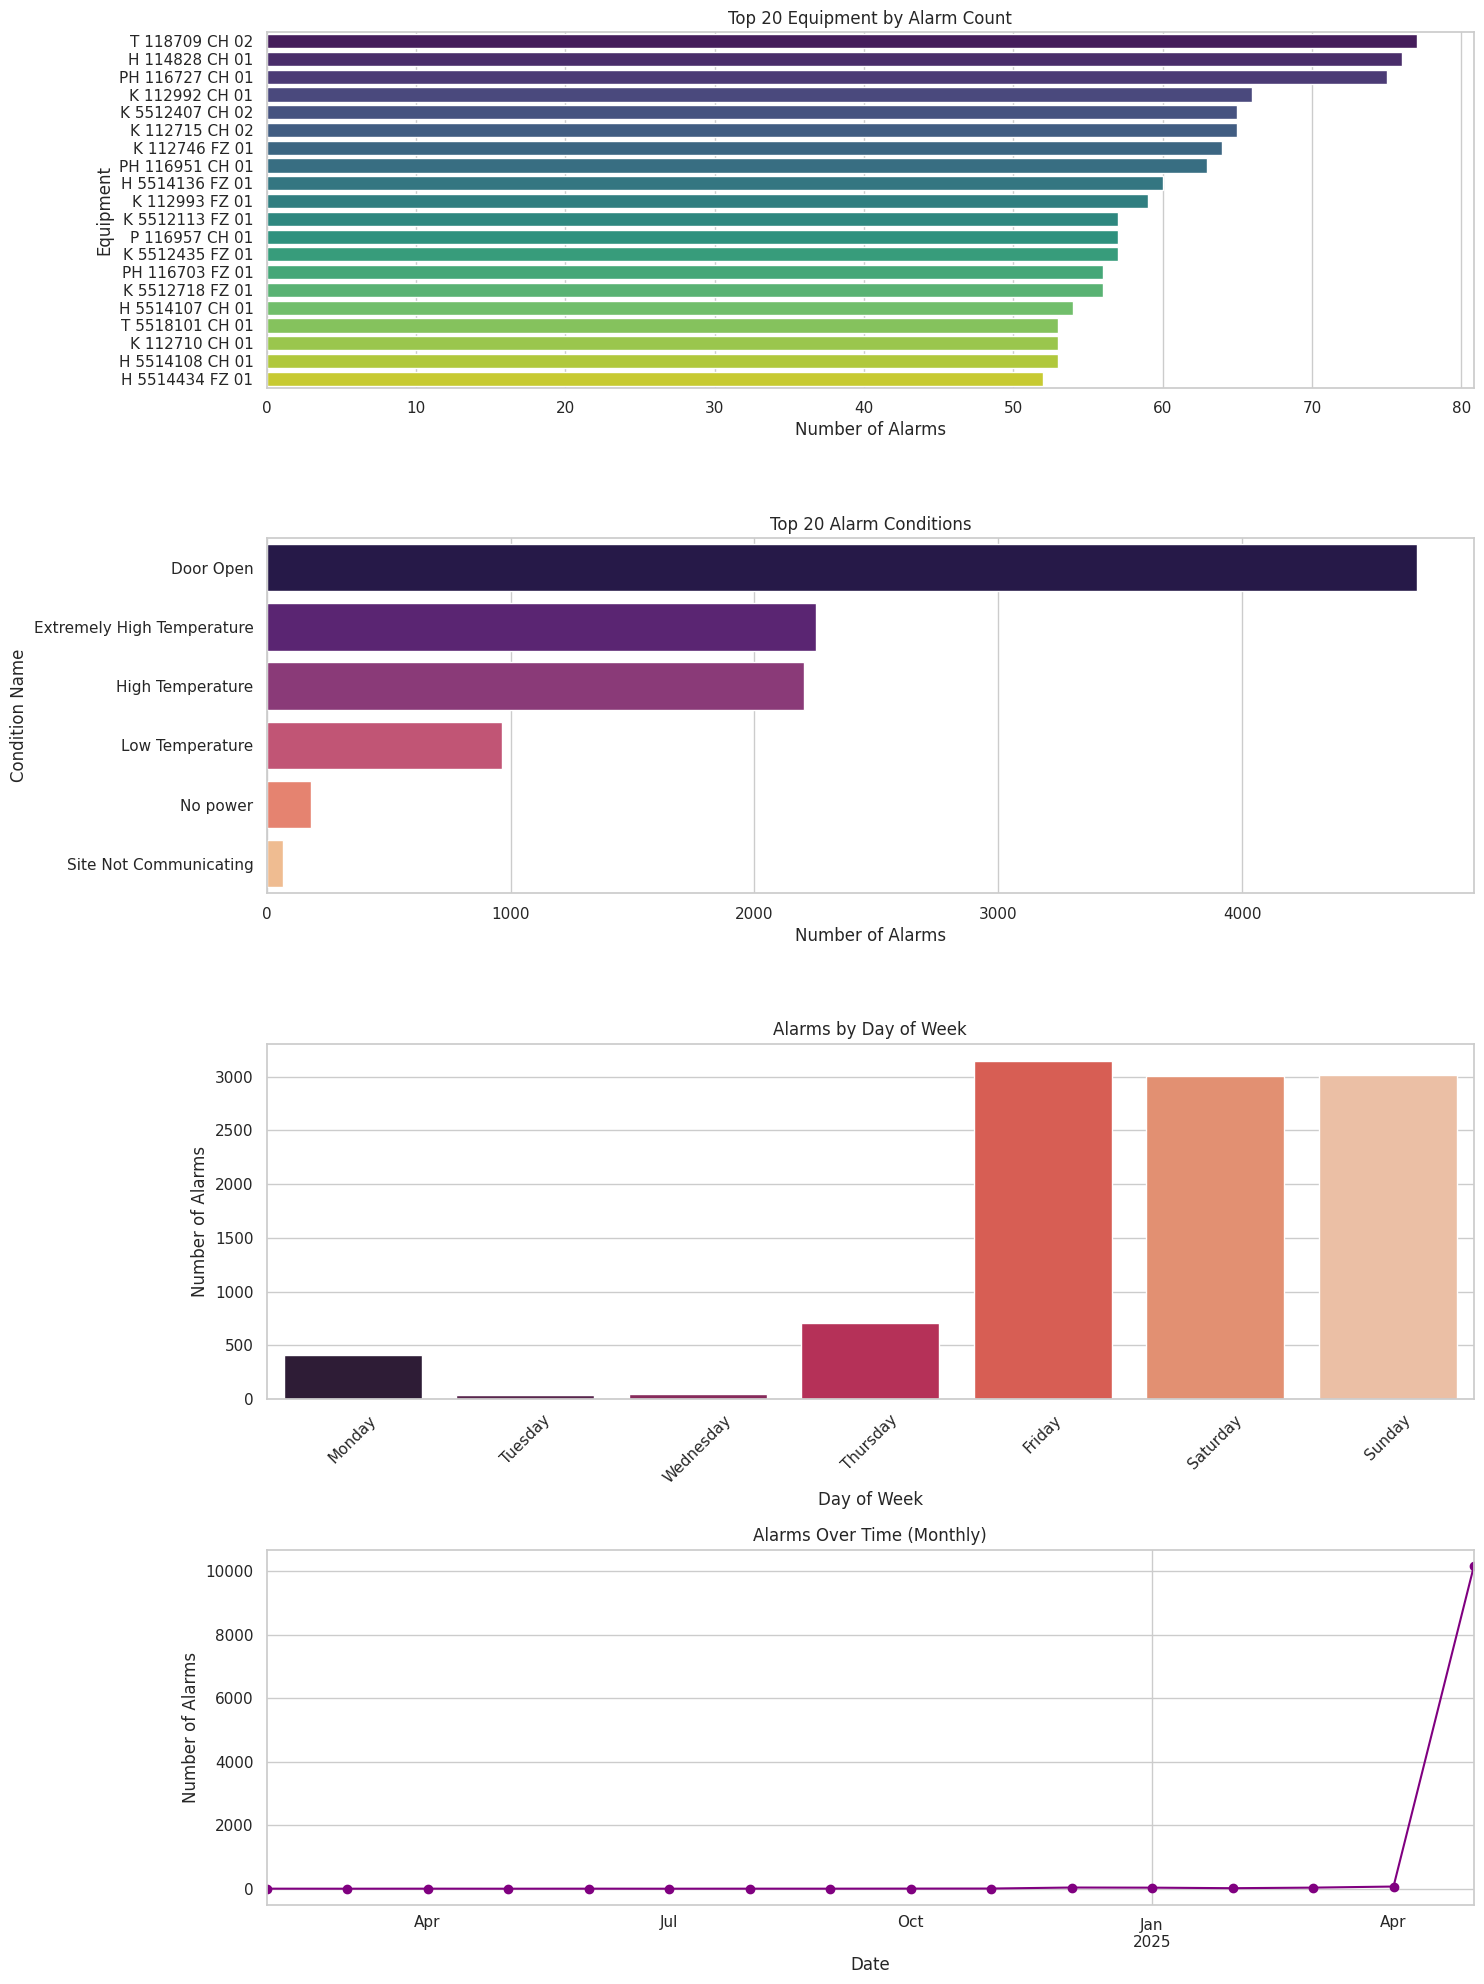

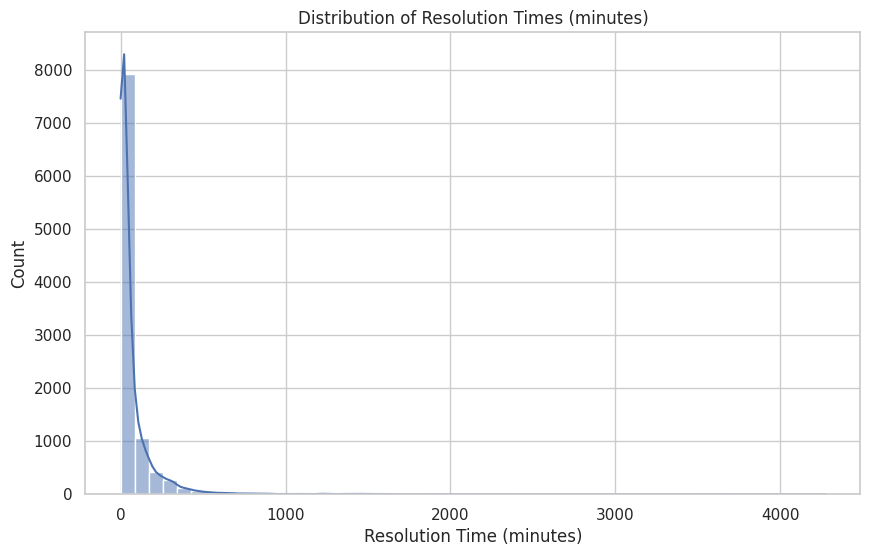


MAIN MENU
1. Alarm Equipment Analysis
2. Alarm Condition Name Analysis
3. Export Full Results
4. Comprehensive Alarm Analysis & Visualization
5. Exit


KeyboardInterrupt: Interrupted by user

In [1]:
import pandas as pd
import json
from google.colab import files
from datetime import datetime, timedelta
import numpy as np
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import seaborn as sns

class CustomJSONEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, (np.integer)):
            return int(obj)
        if isinstance(obj, (np.floating)):
            return float(obj)
        if isinstance(obj, (datetime, pd.Timestamp)):
            return obj.isoformat()
        return super().default(obj)

def calculate_frequency_metrics(data, source_name, dataset_min_date, dataset_max_date):
    source_data = data[data['SOURCE NAME'] == source_name]
    if source_data.empty:
        return None

    source_data = source_data.copy()
    source_data['EVENT DAY'] = pd.to_datetime(source_data['EVENT DAY'])

    # Basic counts
    alarm_days = source_data['EVENT DAY'].dt.normalize().nunique()
    total_alarms = len(source_data)
    total_weeks = ((dataset_max_date - dataset_min_date).days // 7) + 1
    total_months = (dataset_max_date.year - dataset_min_date.year) * 12 + \
                   (dataset_max_date.month - dataset_min_date.month) + 1

    return {
        "alarms_per_active_day": round(total_alarms / alarm_days, 2) if alarm_days > 0 else 0,
        "alarms_per_week": round(total_alarms / total_weeks, 2),
        "monthly_frequency": round(total_alarms / total_months, 2)
    }

def load_and_clean_data():
    """Handles file upload and data cleaning"""
    print("Please upload your Excel file:")
    try:
        uploaded = files.upload()
        if not uploaded:
            raise ValueError("No file uploaded.")
        filename = list(uploaded.keys())[0]
        df = pd.read_excel(filename, header=3)
    except Exception as e:
        print(f"Error uploading or reading file: {e}")
        return None, None, None, None

    # Validate required columns
    required_columns = ['EVENT DAY', 'RESOLVED TIME', 'SOURCE NAME', 'NAME', 'PATH']
    missing_cols = [col for col in required_columns if col not in df.columns]
    if missing_cols:
        print(f"Missing required columns: {', '.join(missing_cols)}")
        return None, None, None, None

    # Data cleaning
    df['EVENT DAY'] = pd.to_datetime(df['EVENT DAY'], format='%d %b %Y %H:%M:%S', errors='coerce', dayfirst=True)
    df['RESOLVED TIME'] = pd.to_datetime(df['RESOLVED TIME'], errors='coerce')
    df['CLIENT NAME'] = df.get('CLIENT NAME', '').replace({'americanauae': 'UAE', 'americanaksa': 'KSA'})
    df['SOURCE NAME'] = df['SOURCE NAME'].str.strip()
    df['resolution_minutes'] = (df['RESOLVED TIME'] - df['EVENT DAY']).dt.total_seconds() / 60
    df['month'] = df['EVENT DAY'].dt.strftime('%B')
    df['week_of_month'] = (df['EVENT DAY'].dt.day - 1) // 7 + 1
    df['week'] = df['EVENT DAY'].dt.isocalendar().week
    df['day_of_week'] = df['EVENT DAY'].dt.day_name()

    # Get dataset date range
    min_date = df['EVENT DAY'].min()
    max_date = df['EVENT DAY'].max()

    # Filter valid resolutions
    valid_resolutions = df.dropna(subset=['RESOLVED TIME'])
    valid_resolutions = valid_resolutions[valid_resolutions['RESOLVED TIME'] >= valid_resolutions['EVENT DAY']]

    return df, valid_resolutions, min_date, max_date

def visualize_data(df):
    """Visualize the alarm data"""
    print("\nGenerating Visualizations...")

    # Set style
    sns.set(style="whitegrid")
    plt.figure(figsize=(15, 20))

    # Create subplots
    fig, axes = plt.subplots(4, 1, figsize=(15, 20))

    # Plot 1: Alarms by Equipment (Top 20)
    top_equipment = df['SOURCE NAME'].value_counts().nlargest(20)
    sns.barplot(x=top_equipment.values, y=top_equipment.index, ax=axes[0], palette="viridis")
    axes[0].set_title('Top 20 Equipment by Alarm Count')
    axes[0].set_xlabel('Number of Alarms')
    axes[0].set_ylabel('Equipment')

    # Plot 2: Alarms by Condition (Top 20)
    top_conditions = df['NAME'].value_counts().nlargest(20)
    sns.barplot(x=top_conditions.values, y=top_conditions.index, ax=axes[1], palette="magma")
    axes[1].set_title('Top 20 Alarm Conditions')
    axes[1].set_xlabel('Number of Alarms')
    axes[1].set_ylabel('Condition Name')

    # Plot 3: Alarms by Day of Week
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    day_counts = df['day_of_week'].value_counts().reindex(day_order)
    sns.barplot(x=day_counts.index, y=day_counts.values, ax=axes[2], palette="rocket")
    axes[2].set_title('Alarms by Day of Week')
    axes[2].set_xlabel('Day of Week')
    axes[2].set_ylabel('Number of Alarms')
    axes[2].tick_params(axis='x', rotation=45)

    # Plot 4: Alarms Over Time (Monthly)
    monthly_counts = df.resample('M', on='EVENT DAY').size()
    monthly_counts.plot(ax=axes[3], marker='o', color='purple')
    axes[3].set_title('Alarms Over Time (Monthly)')
    axes[3].set_xlabel('Date')
    axes[3].set_ylabel('Number of Alarms')

    plt.tight_layout()
    plt.show()

    # Additional visualization: Resolution Time Distribution
    plt.figure(figsize=(10, 6))
    resolved_data = df[df['resolution_minutes'].notna()]
    sns.histplot(resolved_data['resolution_minutes'], bins=50, kde=True)
    plt.title('Distribution of Resolution Times (minutes)')
    plt.xlabel('Resolution Time (minutes)')
    plt.ylabel('Count')
    plt.show()

def analyze_equipment_source(data, full_data, min_date, max_date):
    """Analyze equipment sources with frequency metrics"""
    results = []

    condition_times = full_data[full_data['resolution_minutes'].notna()].groupby(
        ['SOURCE NAME', 'NAME']
    )['resolution_minutes'].mean().reset_index()
    condition_times_dict = condition_times.groupby('SOURCE NAME').apply(
        lambda x: dict(zip(x['NAME'], x['resolution_minutes'].round(2)))
    ).to_dict()

    name_count = full_data.groupby('SOURCE NAME').agg({
        'NAME': lambda x: dict(x.value_counts()),
        'PATH': 'first',
        'month': lambda x: sorted(x.unique(), key=lambda m: pd.to_datetime(m, format='%B').month),
        'week_of_month': lambda x: [f"Week {w}" for w in sorted(x.unique())],
        'resolution_minutes': [
            'size',
            lambda x: x.isna().sum(),
            lambda x: x.notna().sum(),
            'mean'
        ]
    }).reset_index()

    name_count.columns = [
        'Source name', 'Name', 'Path', 'Month', 'Week of Month',
        'Total Count', 'Unresolved', 'Resolved', 'Total Resolution Time'
    ]

    name_count['Frequency'] = name_count['Source name'].apply(
        lambda x: calculate_frequency_metrics(full_data, x, min_date, max_date)
    )

    name_count['Time taken to resolve in minutes'] = name_count.apply(
        lambda row: {
            'Total': round(row['Total Resolution Time'], 2) if pd.notna(row['Total Resolution Time']) else None,
            'By Condition': condition_times_dict.get(row['Source name'], {})
        }, axis=1
    )

    name_count = name_count.drop(columns=['Total Resolution Time'])
    name_count['Name'] = name_count['Name'].apply(lambda x: [f"{k}: {v}" for k, v in x.items()])
    name_count = name_count.sort_values('Total Count', ascending=False)

    return name_count.to_dict('records')

def analyze_specific_equipment(data, source_name, min_date=None, max_date=None):
    """Analyze a specific equipment by SOURCE NAME with frequency metrics"""
    source_name = next((s for s in data['SOURCE NAME'].unique() if s.lower() == source_name.lower()), source_name)
    filtered_data = data[data['SOURCE NAME'] == source_name]
    if filtered_data.empty:
        return f"No data available for equipment: {source_name}"

    # Per-condition resolution times
    condition_times = filtered_data[filtered_data['resolution_minutes'].notna()].groupby(
        ['SOURCE NAME', 'NAME']
    )['resolution_minutes'].mean().reset_index()

    condition_times_dict = condition_times.groupby('SOURCE NAME', group_keys=False).apply(
        lambda x: dict(zip(x['NAME'], x['resolution_minutes'].round(2)))
    ).to_dict()

    # Main aggregation
    results = filtered_data.groupby('SOURCE NAME').agg({
        'NAME': lambda x: dict(x.value_counts()),
        'PATH': 'first',
        'month': lambda x: sorted(x.unique(), key=lambda m: pd.to_datetime(m, format='%B').month),
        'week_of_month': lambda x: [f"Week {w}" for w in sorted(x.unique())],
        'resolution_minutes': [
            'size',
            lambda x: x.isna().sum(),
            lambda x: x.notna().sum(),
            'mean'
        ]
    }).reset_index()

    results.columns = [
        'Source name', 'Name', 'Path', 'Month', 'Week of Month',
        'Total Count', 'Unresolved', 'Resolved', 'Total Resolution Time'
    ]

    # Calculate frequency metrics
    unique_days = filtered_data['EVENT DAY'].dt.normalize().nunique()
    unique_weeks = filtered_data['week'].nunique()
    unique_months = len(results['Month'].iloc[0]) if results['Month'].iloc[0] else 1

    results['Frequency'] = results.apply(lambda row: {
        'alarms_per_active_day': round(row['Total Count'] / unique_days, 2) if unique_days > 0 else 0,
        'alarms_per_week': round(row['Total Count'] / unique_weeks, 2) if unique_weeks > 0 else 0,
        'monthly_frequency': round(row['Total Count'] / unique_months, 2) if unique_months > 0 else 0
    }, axis=1)

    # Time taken to resolve
    results['Time taken to resolve in minutes'] = results.apply(
        lambda row: {
            'Total': round(row['Total Resolution Time'], 2) if pd.notna(row['Total Resolution Time']) else None,
            'By Condition': condition_times_dict.get(row['Source name'], {})
        }, axis=1
    )

    results = results.drop(columns=['Total Resolution Time'])
    results['Name'] = results['Name'].apply(lambda x: [f"{k}: {v}" for k, v in x.items()])

    return results.to_dict('records')

def analyze_condition_name(data, min_date, max_date):
    """Analyze all alarm conditions with frequency metrics"""
    results = {}
    conditions = data['NAME'].unique()

    for cond in conditions:
        cond_key = cond.lower().replace(' ', '_')
        cond_data = data[data['NAME'] == cond]
        if not cond_data.empty:
            cond_analysis = cond_data.groupby('SOURCE NAME').agg({
                'PATH': 'first',
                'resolution_minutes': ['count', 'mean']
            }).reset_index()
            cond_analysis.columns = ['Source name', 'Path', 'count', 'time taken']

            # Add frequency metrics
            cond_analysis['frequency'] = cond_analysis['Source name'].apply(
                lambda x: calculate_frequency_metrics(cond_data, x, min_date, max_date)
            )

            cond_analysis['time taken'] = cond_analysis['time taken'].round(2)
            cond_analysis = cond_analysis.sort_values('count', ascending=False)
            results[cond_key] = cond_analysis.to_dict('records')
        else:
            results[cond_key] = f"No data available for condition: {cond}"

    return results

def analyze_specific_condition(data, condition, min_date, max_date):
    """Analyze specific condition with frequency metrics"""
    condition = next((c for c in data['NAME'].unique() if c.lower() == condition.lower()), condition)
    cond_data = data[data['NAME'] == condition]
    if cond_data.empty:
        return f"No data available for condition: {condition}"

    results = cond_data.groupby('SOURCE NAME').agg({
        'PATH': 'first',
        'resolution_minutes': ['count', 'mean']
    }).reset_index()
    results.columns = ['Source name', 'Path', 'count', 'time taken']

    # Add frequency metrics
    results['frequency'] = results['Source name'].apply(
        lambda x: calculate_frequency_metrics(cond_data, x, min_date, max_date)
    )

    results['time taken'] = results['time taken'].round(2)
    results = results.sort_values('count', ascending=False)

    return results.to_dict('records')

def save_and_download(data, filename_prefix):
    """Save analysis results to JSON and download"""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{filename_prefix}_{timestamp}.json"
    with open(filename, 'w') as f:
        json.dump(data, f, indent=2, cls=CustomJSONEncoder)
    files.download(filename)
    print(f"Downloaded: {filename}")

def comprehensive_analysis(df):
    """Perform comprehensive analysis with visualization"""
    # Initialize analysis results
    analysis_results = {}

    # 1-4. Basic alarm distributions
    analysis_results['alarm_by_client'] = df['CLIENT NAME'].value_counts().to_dict()
    if 'SOURCE TYPE NAME' in df.columns:
        analysis_results['alarm_by_source_type'] = df['SOURCE TYPE NAME'].value_counts().to_dict()
    if 'GROUP' in df.columns:
        analysis_results['alarm_by_group'] = df['GROUP'].value_counts().to_dict()
    analysis_results['alarm_by_name'] = df['NAME'].value_counts().to_dict()

    # 5. Weekly and monthly trends with PATH
    if 'SOURCE NAME' in df.columns and 'PATH' in df.columns:
        source_path_mapping = df.groupby('SOURCE NAME')['PATH'].agg(lambda x: x.mode()[0]).to_dict()

        # Weekly analysis
        weekly = (df.groupby(['SOURCE NAME', df['EVENT DAY'].dt.isocalendar().week.astype(str)])
                  .size().unstack(fill_value=0))
        weekly = weekly.loc[(weekly > 0).any(axis=1)]
        weekly_dict = {}
        for source, week_data in weekly.to_dict('index').items():
            weekly_dict[source] = {
                'path': source_path_mapping.get(source, 'N/A'),
                'counts': {week: count for week, count in week_data.items() if count > 0}
            }
        analysis_results['alarm_by_source_weekly'] = weekly_dict

        # Monthly analysis
        monthly = (df.groupby(['SOURCE NAME', df['EVENT DAY'].dt.month_name().astype(str)])
                   .size().unstack(fill_value=0))
        monthly = monthly.loc[(monthly > 0).any(axis=1)]
        monthly_dict = {}
        for source, month_data in monthly.to_dict('index').items():
            monthly_dict[source] = {
                'path': source_path_mapping.get(source, 'N/A'),
                'counts': {month: count for month, count in month_data.items() if count > 0}
            }
        analysis_results['alarm_by_source_monthly'] = monthly_dict

    # 6. Hourly distribution
    df['hour'] = df['EVENT DAY'].dt.hour.astype(str)
    analysis_results['alarm_by_hour'] = df['hour'].value_counts().sort_index().to_dict()

    # 7. Top/Bottom 20 sources with PATH
    if 'SOURCE NAME' in df.columns and 'PATH' in df.columns:
        source_counts = df['SOURCE NAME'].value_counts()
        analysis_results['top20_sources'] = {
            source: {
                'count': int(count),
                'path': source_path_mapping.get(source, 'N/A')
            } for source, count in source_counts.head(20).items()
        }
        analysis_results['bottom20_sources'] = {
            source: {
                'count': int(count),
                'path': source_path_mapping.get(source, 'N/A')
            } for source, count in source_counts.tail(20).items()
        }

    # 8. Resolution time stats
    valid_resolutions = df.dropna(subset=['RESOLVED TIME'])
    valid_resolutions = valid_resolutions[valid_resolutions['RESOLVED TIME'] >= valid_resolutions['EVENT DAY']]
    analysis_results['resolution_time_stats'] = valid_resolutions.groupby('NAME')['resolution_minutes'].agg(
        ['mean', 'median', 'count']).round(2).to_dict('index')

    # 9. Highest and Lowest 20 resolution times with PATH
    if 'SOURCE NAME' in df.columns and 'PATH' in df.columns:
        # Get top 20 longest resolutions
        top20_longest = valid_resolutions.nlargest(20, 'resolution_minutes')[['SOURCE NAME', 'PATH', 'resolution_minutes', 'EVENT DAY', 'RESOLVED TIME']]
        analysis_results['top20_longest_resolutions'] = [
            {
                'source': row['SOURCE NAME'],
                'path': row['PATH'],
                'time_minutes': round(row['resolution_minutes'], 2),
                'event_day': row['EVENT DAY'].isoformat(),
                'resolved_time': row['RESOLVED TIME'].isoformat()
            } for _, row in top20_longest.iterrows()
        ]

        # Get top 20 fastest resolutions
        top20_fastest = valid_resolutions.nsmallest(20, 'resolution_minutes')[['SOURCE NAME', 'PATH', 'resolution_minutes', 'EVENT DAY', 'RESOLVED TIME']]
        analysis_results['top20_fastest_resolutions'] = [
            {
                'source': row['SOURCE NAME'],
                'path': row['PATH'],
                'time_minutes': round(row['resolution_minutes'], 2),
                'event_day': row['EVENT DAY'].isoformat(),
                'resolved_time': row['RESOLVED TIME'].isoformat()
            } for _, row in top20_fastest.iterrows()
        ]

    # Reorganize results with resolution extremes before temporal trends
    final_results = {
        "summary": {
            "total_alarms": len(df),
            "resolved_alarms": len(valid_resolutions),
            "resolution_rate in Percentage": str(round(len(valid_resolutions)/len(df)*100, 2)) + "%",
            "time_period": {
                "start": df['EVENT DAY'].min().isoformat(),
                "end": df['EVENT DAY'].max().isoformat()
            }
        },
        "distributions": {
            "by_client": analysis_results['alarm_by_client'],
            "by_type": analysis_results.get('alarm_by_source_type', {}),
            "by_group": analysis_results.get('alarm_by_group', {}),
            "by_name": analysis_results['alarm_by_name'],
            "by_hour": analysis_results['alarm_by_hour']
        },
        "source_analysis": {
            "top_20": analysis_results.get('top20_sources', {}),
            "bottom_20": analysis_results.get('bottom20_sources', {})
        },
        "performance": {
            "resolution_times": analysis_results['resolution_time_stats'],
            "sla_compliance/Resolved within the time limit": {
                "within_15min": round((valid_resolutions['resolution_minutes'] <= 15).mean()*100, 2),
                "within_30min": round((valid_resolutions['resolution_minutes'] <= 30).mean()*100, 2),
                "within_1hour": round((valid_resolutions['resolution_minutes'] <= 60).mean()*100, 2)
            }
        },
        "resolution_extremes": {
            "longest_20_resolutions": analysis_results.get('top20_longest_resolutions', []),
            "fastest_20_resolutions": analysis_results.get('top20_fastest_resolutions', [])
        },
        "temporal_trends": {
            "weekly": analysis_results.get('alarm_by_source_weekly', {}),
            "monthly": analysis_results.get('alarm_by_source_monthly', {})
        }
    }

    # Save final organized results
    with open('comprehensive_alarm_analysis.json', 'w') as f:
        json.dump(final_results, f, indent=2, cls=CustomJSONEncoder)
    files.download('comprehensive_alarm_analysis.json')

    # Show visualizations only when this function is called (option 4)
    visualize_data(df)

def main():
    df, valid_resolutions, min_date, max_date = load_and_clean_data()
    if df is None or valid_resolutions is None:
        print("Exiting due to data loading error.")
        return

    equipment_results = analyze_equipment_source(valid_resolutions, df, min_date, max_date)
    condition_results = analyze_condition_name(valid_resolutions, min_date, max_date)

    while True:
        print("\nMAIN MENU")
        print("1. Alarm Equipment Analysis")
        print("2. Alarm Condition Name Analysis")
        print("3. Export Full Results")
        print("4. Comprehensive Alarm Analysis & Visualization")
        print("5. Exit")

        main_choice = input("Select option: ")

        if main_choice == "1":
            while True:
                print("\nALARM EQUIPMENT ANALYSIS")
                print("1. All equipment analysis")
                print("2. Specific equipment analysis")
                print("3. Back to main menu")

                equip_choice = input("Select analysis: ")

                if equip_choice == "1":
                    display(Markdown("## All Equipment Analysis"))
                    display(pd.DataFrame(equipment_results))
                    save_and_download(equipment_results, "Equipment_All_Analysis")
                elif equip_choice == "2":
                    print("Available equipment:", ", ".join(df['SOURCE NAME'].unique()))
                    source_name = input("Enter equipment name: ")
                    specific_results = analyze_specific_equipment(df, source_name, min_date, max_date)
                    if isinstance(specific_results, str):
                        print(specific_results)
                    else:
                        display(Markdown(f"## Analysis for: {source_name}"))
                        display(pd.DataFrame(specific_results))
                        save_and_download(specific_results, f"Equipment_{source_name.replace(' ', '_')}_Analysis")
                elif equip_choice == "3":
                    break
                else:
                    print("Invalid selection")

        elif main_choice == "2":
            while True:
                print("\nALARM CONDITION ANALYSIS")
                print("1. All condition analysis")
                print("2. Specific condition analysis")
                print("3. Back to main menu")

                cond_choice = input("Select analysis: ")

                if cond_choice == "1":
                    display(Markdown("## All Alarm Conditions"))
                    for cond, result in condition_results.items():
                        display(Markdown(f"### {cond.replace('_', ' ').title()}"))
                        if isinstance(result, str):
                            print(result)
                        else:
                            display(pd.DataFrame(result))
                    save_and_download(condition_results, "Condition_All_Analysis")
                elif cond_choice == "2":
                    print("Available conditions:", ", ".join(df['NAME'].unique()))
                    condition = input("Enter condition name: ")
                    specific_results = analyze_specific_condition(df, condition, min_date, max_date)
                    if isinstance(specific_results, str):
                        print(specific_results)
                    else:
                        display(Markdown(f"## Analysis for: {condition}"))
                        display(pd.DataFrame(specific_results))
                        save_and_download(specific_results, f"Condition_{condition.replace(' ', '_')}_Analysis")
                elif cond_choice == "3":
                    break
                else:
                    print("Invalid selection")

        elif main_choice == "3":
            full_results = {
                "equipment_analysis": equipment_results,
                "condition_analysis": condition_results
            }
            save_and_download(full_results, "Full_Analysis_Results")
            print("Full results exported")

        elif main_choice == "4":
            print("Running Comprehensive Alarm Analysis & Visualization...")
            comprehensive_analysis(df)

        elif main_choice == "5":
            print("Exiting program...")
            break
        else:
            print("Invalid selection")

if __name__ == "__main__":
    main()